# Fitting XGBoost Regression

In [31]:
import xgboost
import Data_Helper as DH
import lendingclub
import prediction
import investment
import backtester

import numpy as np
import pandas as pd
import json
import time
import sklearn
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None  # default='warn'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Instantiate Object

In [2]:
# initialize config object
config = lendingclub.ConfigData("config_data_dummy.ini")

# initialize lendingclup api object
lc = lendingclub.LendingClub(config)

# initialize data transformer
transformer = DH.Transformer_full()

# initialize DataHelper
periodStart = ("Q1", "2014")
periodEnd = ("Q2", "2016")
DataHelper = DH.DataHelper(periodStart, periodEnd, transformer, lc)

In [3]:
# set training data
DataHelper.set_training_dataset()

In [4]:
# set test data
DataHelper.set_test_dataset(["LoanStats_2016Q3.csv", "LoanStats_2016Q4.csv"])

## Check

In [16]:
# xgb = prediction.ModelXGBRegression()

In [17]:
# # get training/test for this model
# training, test = xgb.get_data_for_model(DataHelper.training, DataHelper.test)

In [18]:
# param = {
#     "n_estimators": 100,
#     "learning_rate": 0.1,
#     "max_depth": 6, 
#     "min_child_weight": 1,
#     "gamma": 0,
#     "subsample": 0.8,
#     "colsample_bytree": 0.8,
#     "reg_alpha": 0
# }

In [20]:
# # Check time
# start = time.time()

# model = xgb.fit_model(training, **param)
# score = xgb.test_model(test, model)
# print("Raw test score:",score)

# end = time.time()
# print(end - start)

Raw test score: {'score': -0.0002848936528052626, 'MSE': 0.02510434902522346}
63.770185232162476


## XGBoost Regression - CV

### Quick train for n_estimators

With default parameters and 0.01 learning rate, quickly fit the n_estimators. This will be fine tuned later.

In [5]:
# instantiate our model
xgb = prediction.ModelXGBRegression()

In [6]:
# get training/test for this model
training, test = xgb.get_data_for_model(DataHelper.training, DataHelper.test)

In [7]:
# get CVs
CVs = DataHelper.get_cross_validation_data(fold=5)

In [8]:
param = {
    "n_estimators": 5000,
    "learning_rate": 0.01,
    "max_depth": 6, 
    "min_child_weight": 1,
    "gamma": 0,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 0
}

In [9]:
param["n_estimators"] = xgb.fit_n_estimator(training, 5, 50, **param)

stop at 2818 test-mean-rmse: 0.1285, test-std-rmse: 0.0003


### max_depth and min_child_weight

In [9]:
param["n_estimators"] = 2818

In [10]:
param_CV = {x:[y] for x,y in param.items()}
param_CV["max_depth"] = list(range(3,10,2))
param_CV["min_child_weight"] = list(range(1,6,2))
grids = xgb.construct_grids(**param_CV)

In [11]:
# tune parameters with CV
scores = xgb.tune_parameters(DataHelper.training, CVs, grids, verbose=False)

In [12]:
# choose best Grid
_, avg_score, param = xgb.best_grid(scores, "MSE")
print(avg_score)
print("max_depth: {}, min_child_weight: {}".format(param["max_depth"], param["min_child_weight"]))

0.01652263047027628
max_depth: 7, min_child_weight: 1


Further tuning with finer grid...

In [16]:
param

{'n_estimators': 2818,
 'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_weight': 1,
 'gamma': 0,
 'subsample': 0.8,
 'colsample_bytree': 0.8,
 'reg_alpha': 0}

In [13]:
param_CV = {x:[y] for x,y in param.items()}
param_CV["max_depth"] = [6,7,8]
param_CV["min_child_weight"] = [1,2]
grids = xgb.construct_grids(**param_CV)

In [14]:
# tune parameters with CV
scores = xgb.tune_parameters(DataHelper.training, CVs, grids, verbose=False)

In [15]:
# choose best Grid
_, avg_score, param = xgb.best_grid(scores, "MSE")
print(avg_score)
print("max_depth: {}, min_child_weight: {}".format(param["max_depth"], param["min_child_weight"]))

0.01652094637156672
max_depth: 7, min_child_weight: 2


## Tune Gamma

In [16]:
param_CV = {x:[y] for x,y in param.items()}
param_CV["gamma"] = [i/10.0 for i in range(0,21,4)]
grids = xgb.construct_grids(**param_CV)

In [17]:
# tune parameters with CV
scores = xgb.tune_parameters(DataHelper.training, CVs, grids, verbose=False)

In [18]:
# choose best Grid
_, avg_score, param = xgb.best_grid(scores, "MSE")
print(avg_score)
print("gamma: {}".format(param["gamma"]))

0.01652094637156672
gamma: 0.0


## Refit N_estimator

In [19]:
param["n_estimators"] = xgb.fit_n_estimator(training, 5, 50, **param)

stop at 2030 test-mean-rmse: 0.1285, test-std-rmse: 0.0003


### Tune subsample and colsample_bytree

In [21]:
param_CV = {x:[y] for x,y in param.items()}
param_CV["subsample"] = [i/10 for i in range(5,9)]
param_CV["colsample_bytree"] = [i/10 for i in range(5,9)]
grids = xgb.construct_grids(**param_CV)

In [22]:
# tune parameters with CV
scores = xgb.tune_parameters(DataHelper.training, CVs, grids, verbose=False)

In [23]:
# choose best Grid
_,avg_score, param = xgb.best_grid(scores, "MSE")
print(avg_score)
print("subsample: {}, colsample_bytree: {}".format(param["subsample"], param["colsample_bytree"]))

0.01652369274472193
subsample: 0.8, colsample_bytree: 0.8


Further tuning..

In [28]:
param_CV = {x:[y] for x,y in param.items()}
param_CV["subsample"] = [i/100.0 for i in range(75,90,5)]
param_CV["colsample_bytree"] = [i/100.0 for i in range(75,90,5)]
grids = xgb.construct_grids(**param_CV)

In [29]:
# tune parameters with CV
scores = xgb.tune_parameters(DataHelper.training, CVs, grids, verbose=False)

In [30]:
# choose best Grid
_, avg_score, param = xgb.best_grid(scores, "MSE")
print(avg_score)
print("subsample: {}, colsample_bytree: {}".format(param["subsample"], param["colsample_bytree"]))

0.01652369274472193
subsample: 0.8, colsample_bytree: 0.8


### Tune Regularization Parameters

In [31]:
param_CV = {x:[y] for x,y in param.items()}
param_CV["reg_alpha"] = [0, 1e-4, 1e-2, 0.1]
grids = xgb.construct_grids(**param_CV)

In [32]:
# tune parameters with CV
scores = xgb.tune_parameters(DataHelper.training, CVs, grids, verbose=False)

In [35]:
# choose best Grid
_, avg_score, param = xgb.best_grid(scores, "MSE")
print(avg_score)
print("reg_alpha: {}".format(param["reg_alpha"]))

0.01652036196580186
reg_alpha: 0.1


Now apply this parameters to our model and check the AUC.

In [36]:
model = xgb.fit_model(training, **param)
score = xgb.test_model(test, model)
print("Raw test score:", score)

Raw test score: {'score': 0.005384272492057862, 'MSE': 0.02496206883436413}


### Reducing learning rate

Let's decrease the learning rate and increase the n_estimators.

In [37]:
param_CV = {x:[y] for x,y in param.items()}
param_CV["n_estimators"] = [2818-500, 2818, 2818+500, 2818+1000]
param_CV["learning_rate"] = [0.005, 0.01]
grids = xgb.construct_grids(**param_CV)

In [38]:
# tune parameters with CV
scores = xgb.tune_parameters(DataHelper.training, CVs, grids, verbose=False)

In [39]:
# choose best Grid
_, avg_score, param = xgb.best_grid(scores, "MSE")
print(avg_score)
print("n_estimators: {}, learning_rate: {}".format(param["n_estimators"], param["learning_rate"]))

0.016517428809182663
n_estimators: 2818, learning_rate: 0.01


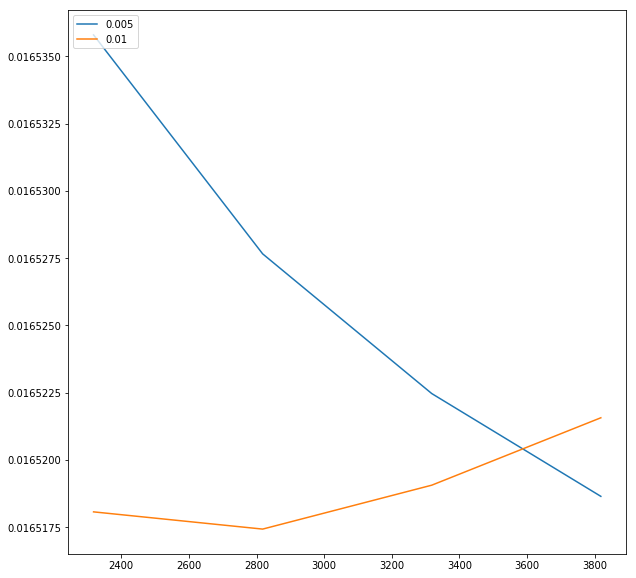

In [41]:
plt.figure(figsize=(10,10))
for lr in param_CV["learning_rate"]:
    aucs = [x["avg_score"]["MSE"] for x in scores if x["grid"]["learning_rate"]==lr]
    plt.plot(param_CV["n_estimators"], aucs)

plt.legend(param_CV["learning_rate"], loc='upper left')
plt.show()

In [42]:
param

{'n_estimators': 2818,
 'learning_rate': 0.01,
 'max_depth': 7,
 'min_child_weight': 2,
 'gamma': 0.0,
 'subsample': 0.8,
 'colsample_bytree': 0.8,
 'reg_alpha': 0.1}

## Final Fitting

In [2]:
# initialize config object
config = lendingclub.ConfigData("config_data_dummy.ini")

# initialize lendingclup api object
lc = lendingclub.LendingClub(config)

# initialize data transformer
transformer = DH.Transformer_full()

# initialize DataHelper
periodStart = ("Q1", "2014")
periodEnd = ("Q2", "2016")
DataHelper = DH.DataHelper(periodStart, periodEnd, transformer, lc)

In [3]:
# set training data
DataHelper.set_training_dataset()

In [4]:
# set test data
DataHelper.set_test_dataset(["LoanStats_2016Q3.csv", "LoanStats_2016Q4.csv"])

In [5]:
# instantiate our model
xgb = prediction.ModelXGBRegression()

In [6]:
# get training/test for this model
training, test = xgb.get_data_for_model(DataHelper.training, DataHelper.test)

In [7]:
param = {
    'n_estimators': 2818,
    'learning_rate': 0.01,
    'max_depth': 7,
    'min_child_weight': 2,
    'gamma': 0.0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1
}

In [8]:
# Check time
start = time.time()

model = xgb.fit_model(training, **param)
score = xgb.test_model(test, model)
print("test score:",score)

end = time.time()
print(end - start)

test score: {'score': 0.00600548226261699, 'MSE': 0.024946478209136307}
1916.4901356697083


In [9]:
scaler = xgb.get_scaler(DataHelper.training)

## Save Result

In [10]:
filename = "xgb_regression_20190704.sav"

In [11]:
xgb.save_model(model,scaler,training,filename)

Model is saved on xgb_regression_20190704.sav


## Predict listed loan by saved model

In [21]:
filename = "xgb_regression_20190704.sav"

In [22]:
# instantiate from beginning
xgb = prediction.ModelXGBRegression(filename)

In [23]:
# update from the saved model
xgb.set_model_from_file()

Model is loaded from xgb_regression_20190704.sav


In [24]:
# check model description
xgb.model_description

'XGBoost Regression Object, time: 07/04/2019'

In [25]:
# get listed loan
loans = DataHelper.get_listed_loandata()
loans.shape

(78, 81)

In [26]:
# prediction
pred = xgb.predict_model(loans)
pred.shape

(78,)

In [27]:
pred

array([0.7336142 , 0.68930864, 0.67315245, 0.62848943, 0.72306395,
       0.70338845, 0.6985779 , 0.7163183 , 0.70867515, 0.65148425,
       0.72765446, 0.66756594, 0.67225254, 0.67706704, 0.6895717 ,
       0.59626496, 0.73226845, 0.71391726, 0.6968492 , 0.7245303 ,
       0.72483647, 0.693724  , 0.6817036 , 0.6781675 , 0.68532866,
       0.654957  , 0.7113811 , 0.67647356, 0.66168153, 0.72031283,
       0.71922314, 0.6453545 , 0.6843398 , 0.7152225 , 0.6987675 ,
       0.6880803 , 0.6840101 , 0.62871635, 0.7142276 , 0.7060126 ,
       0.7240273 , 0.68732035, 0.6573921 , 0.7282614 , 0.7209338 ,
       0.7070019 , 0.64081866, 0.7202494 , 0.727617  , 0.70872176,
       0.69139934, 0.6982113 , 0.68465525, 0.70148265, 0.68785155,
       0.68320465, 0.71242046, 0.6151661 , 0.7015586 , 0.6671086 ,
       0.6428145 , 0.7021723 , 0.6736733 , 0.7563835 , 0.67550987,
       0.71429366, 0.69692343, 0.583964  , 0.7043705 , 0.7335577 ,
       0.67704904, 0.70441145, 0.67132425, 0.69832945, 0.72095

## Backtesting

Ok so the model is sill not improved. The return stays at 5.15% at most.

In [32]:
def optimize_cut_conservative(cuts, initialInvest, DataHelper, model, strat, n, plot=False):
    
    profits = []
    for cut in cuts:
        
        # set cut of strateg
        strat.cut = cut
        
        # set initial investment of Backtester
        Backtester = backtester.Backtester(DataHelper, model, strat, n)
        Backtester.initialInvest = initialInvest
        
        # append return
        _, r, _ = Backtester.backtest_OOT(returnAll=False)
        profits.append(r)
        
    if plot:
        plt.plot(profits)
        plt.show()
        
    return profits

In [33]:
def optimize_initial_conservative(cuts, initialInvests, DataHelper, model, strat, n):
    
    results = []
    
    plt.figure(figsize=(10,8))
    for initial in initialInvests:
        profits = optimize_cut_conservative(cuts, initial, DataHelper, model, strat, n)
        
        # append maximum
        ind = np.argmax(profits)
        results.append({"initialInvest":initial,"cut":cuts[ind], "return": profits[ind]})
        plt.plot(cuts, profits)
    
    names = ["m:{}".format(x) for x in initialInvests]
    plt.legend(names, loc='upper left')
    plt.show()
    return results

In [34]:
strat = investment.StrategyRegSimple(xgb)
print(strat.description())

This strategy chooses loans basaed on the simple epected return cut. In other words, it only invests to the loans with the model scores higher than the cut. It further filters out the selected loan by FICO score.


In [39]:
np.log(1.05)

0.04879016416943205

In [44]:
initial = 10000
cuts = np.array(range(20,41)) * 0.025 # [0.60.7, 0.725, 0.75, 0.775, 0.8, 0.825, 0.85, 0.875]

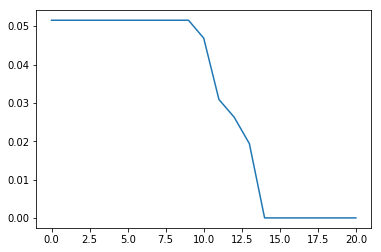

[0.05153889943359505,
 0.05153889943359505,
 0.05153889943359505,
 0.05153889943359505,
 0.05153889943359505,
 0.05153889943359505,
 0.05153889943359505,
 0.05153889943359505,
 0.05153889943359505,
 0.05153889943359505,
 0.04686370414106009,
 0.030873693157833556,
 0.02626837011401743,
 0.019357051458924673,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [45]:
profits = optimize_cut_conservative(cuts, initial, DataHelper, xgb, strat, 1, plot=True)
profits

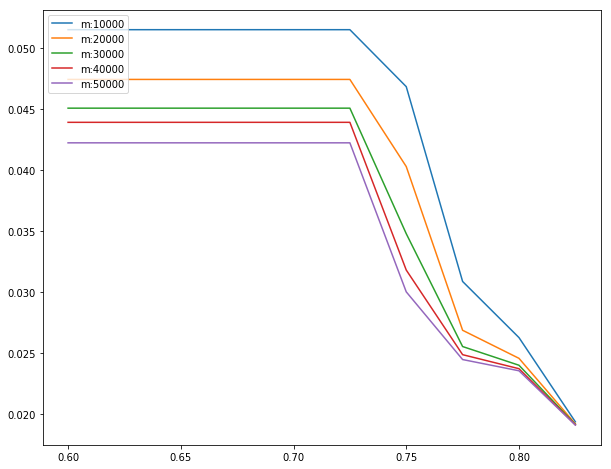

[{'initialInvest': 10000, 'cut': 0.6, 'return': 0.05153889943359505},
 {'initialInvest': 20000, 'cut': 0.6, 'return': 0.04745661737736196},
 {'initialInvest': 30000, 'cut': 0.6, 'return': 0.045097731580849766},
 {'initialInvest': 40000, 'cut': 0.6, 'return': 0.043935740638908025},
 {'initialInvest': 50000, 'cut': 0.6, 'return': 0.04225228207824488}]

In [47]:
initialInvests = np.array(range(1,6)) * 10000
cuts = [0.6, 0.625, 0.65, 0.675, 0.7, 0.725, 0.75, 0.775, 0.8, 0.825]
profits = optimize_initial_conservative(cuts, initialInvests, DataHelper, xgb, strat, 1)
profits